In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 获取当前目录
current_dir = os.getcwd()

# 添加 `interClusLib` 的上级目录到 Python 路径
sys.path.append(os.path.join(current_dir, ".."))

import interClusLib
from interClusLib.IntervalData import IntervalData
from interClusLib.metric import *
from interClusLib.clustering.IntervalKMeans import IntervalKMeans

print("interClusLib Path:", interClusLib.__file__)

random_data = IntervalData.random_data(40, 4)
print("\n Random Interval Data:")
print(random_data.data)
random_data.summary()

interClusLib Path: /Users/jiashuchen/Desktop/InterClusLib/examples/../interClusLib/__init__.py

 Random Interval Data:
    feature_1_lower  feature_1_upper  feature_2_lower  feature_2_upper  \
0         37.435840        64.742205        28.648928        63.081439   
1         30.921735        85.106087        34.753937        38.210294   
2          7.066334        55.760926        36.074886        36.734654   
3         39.718623        40.003226        12.823626        90.525212   
4         46.916383        92.628759        11.135351        35.264527   
5         18.093394        94.765281        40.353060        92.345560   
6         52.572785        70.685615        81.175686        88.373307   
7         58.683401        71.876645        77.155018        77.371397   
8         27.955772        32.187337        13.857956        55.618649   
9         87.774342        88.412871        22.960471        33.867793   
10         0.816725        97.937338        74.716222        94.108

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as mpatches
import matplotlib as mpl

class IntervalParallelCoordinates:

    # Functions for generating Bezier curves
    @staticmethod
    def generate_bezier_curve(p0, p1, p2, p3, num_points=50):
        """Generate a cubic Bezier curve from 4 control points."""
        t = np.linspace(0, 1, num_points)
        
        # Cubic Bezier formula
        curve = (1-t)**3 * p0[:, np.newaxis] + \
                3 * (1-t)**2 * t * p1[:, np.newaxis] + \
                3 * (1-t) * t**2 * p2[:, np.newaxis] + \
                t**3 * p3[:, np.newaxis]
        
        return curve.T

    @staticmethod
    def compute_control_points(p_left, p_right, alpha=1/6, beta=0.8, centroid=None):
        """
        Compute the control points for a cubic Bezier curve between two points
        with proper C1 continuity.
        
        Parameters:
        - p_left: point at the left axis
        - p_right: point at the right axis
        - alpha: smoothness scale (0-0.25)
        - beta: bundling strength (0-1)
        - centroid: cluster centroid position at the virtual axis
        """
        # Middle point (original polyline intersection with virtual axis)
        mid_x = (p_left[0] + p_right[0]) / 2
        mid_y = (p_left[1] + p_right[1]) / 2
        
        # If we have a centroid for bundling, adjust the mid point
        if centroid is not None:
            # Original midpoint
            q = np.array([mid_x, mid_y])
            # Adjust midpoint towards centroid based on beta
            q_prime = q + beta * (centroid - q)
            mid_x, mid_y = q_prime
        
        # Control points for the left curve segment
        cp1_x = p_left[0] + alpha * (mid_x - p_left[0])
        cp1_y = p_left[1]
        
        # Control points for the right curve segment
        cp2_x = mid_x - alpha * (mid_x - p_left[0])
        cp2_y = mid_y
        
        cp3_x = mid_x + alpha * (p_right[0] - mid_x)
        cp3_y = mid_y
        
        cp4_x = p_right[0] - alpha * (p_right[0] - mid_x)
        cp4_y = p_right[1]
        
        return (mid_x, mid_y), (cp1_x, cp1_y), (cp2_x, cp2_y), (cp3_x, cp3_y), (cp4_x, cp4_y)

    @staticmethod
    def plot_interval_curves(data=None, feature_names=None, clusters=None, centroids=None, alpha=1/6, beta=0.8, ax=None, 
                    use_bundling=True, use_color=True, uncertainty_alpha=0.2):
        """
        Plot parallel coordinates with curve bundling for interval data.
        
        Parameters:
        - data: interval data in format (n_samples, n_dim, 2), where the last dimension represents [lower, upper]
               Can be None if only plotting centroids
        - feature_names: list of feature names, if None, will auto-generate names
        - clusters: cluster assignments, if None, all data will be treated as one cluster
        - centroids: custom centroids data in format (n_clusters, n_dim, 2) 
                    where the last dimension represents [lower, upper]
                    Can be provided without data to only plot centroids
        - alpha: smoothness scale (0-0.25)
        - beta: bundling strength (0-1)
        - ax: matplotlib axis
        - use_bundling: whether to use curve bundling
        - use_color: whether to use color coding
        - uncertainty_alpha: transparency of uncertainty regions
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))
            
        # Ensure either data or centroids (or both) are provided
        if data is None and centroids is None:
            raise ValueError("Either data or centroids must be provided")
            
        # Determine the number of features from provided data or centroids
        if data is not None:
            n_samples, n_features = data.shape[0], data.shape[1]
        else:  # Use centroids to determine n_features
            n_features = centroids.shape[1]
            n_samples = 0
        
        # If feature_names is None, auto-generate feature names
        if feature_names is None:
            feature_names = [f"Feature {i+1}" for i in range(n_features)]
        
        # Set up axes - dynamically adapt to number of dimensions
        axes_x = np.linspace(0, 1, n_features)
        
        # Extract data bounds for normalization
        if data is not None:
            # Extract lower and upper bounds
            data_lower = data[:, :, 0]
            data_upper = data[:, :, 1]
            data_center = (data_lower + data_upper) / 2
            
            # Initial min/max from data
            all_mins = np.min(data_lower, axis=0)
            all_maxs = np.max(data_upper, axis=0)
        else:
            # Initialize with centroids if no data
            all_mins = np.min(centroids[:, :, 0], axis=0)
            all_maxs = np.max(centroids[:, :, 1], axis=0)
            
        # Update min/max with centroids if available
        if centroids is not None and data is not None:
            centroid_mins = np.min(centroids[:, :, 0], axis=0)
            centroid_maxs = np.max(centroids[:, :, 1], axis=0)
            all_mins = np.minimum(all_mins, centroid_mins)
            all_maxs = np.maximum(all_maxs, centroid_maxs)
        
        # Handle potential division by zero
        range_values = all_maxs - all_mins
        range_values[range_values == 0] = 1  # Avoid division by zero
        
        # Normalize data if present
        if data is not None:
            norm_data_lower = (data_lower - all_mins) / range_values
            norm_data_upper = (data_upper - all_mins) / range_values
            norm_data_center = (data_center - all_mins) / range_values
        
        # Draw the axes with better spacing
        for i, x in enumerate(axes_x):
            ax.axvline(x=x, ymin=0, ymax=1, color='black', alpha=0.5)
            ax.text(x, 1.07, feature_names[i], ha='center', va='bottom', fontsize=10, fontweight='bold')
        
            # Format min and max values
            min_val = all_mins[i]
            max_val = all_maxs[i]
            
            # Determine appropriate formatting
            if abs(min_val) < 0.1 or abs(min_val) > 1000:
                min_format = "{:.2e}"
            elif min_val == int(min_val):
                min_format = "{:.0f}"
            else:
                min_format = "{:.1f}"
                
            if abs(max_val) < 0.1 or abs(max_val) > 1000:
                max_format = "{:.2e}"
            elif max_val == int(max_val):
                max_format = "{:.0f}"
            else:
                max_format = "{:.1f}"
            
            # Add value labels with better spacing
            ax.text(x, -0.07, min_format.format(min_val), ha='center', va='top', fontsize=9)
            ax.text(x, 1.0, max_format.format(max_val), ha='center', va='bottom', fontsize=9)
        
        # Set up cluster information
        if data is not None:
            if clusters is None:
                clusters = np.zeros(n_samples, dtype=int)
                
            n_clusters = max(len(np.unique(clusters)), 1)
        elif centroids is not None:
            # If only centroids, set n_clusters based on centroids
            n_clusters = centroids.shape[0]
            # Create a dummy clusters array if data is None
            clusters = np.array([]) if clusters is None else clusters
            
        # Generate color map
        colors = [plt.cm.get_cmap('tab10')(i/max(1, n_clusters-1)) for i in range(n_clusters)]
        
        # Process centroids if provided
        if centroids is not None:
            # Ensure centroids has correct shape
            if len(centroids.shape) != 3 or centroids.shape[1] != n_features or centroids.shape[2] != 2:
                raise ValueError(f"centroids should have shape (n_clusters, {n_features}, 2), got {centroids.shape}")
            
            # Normalize centroids
            centroid_lower = centroids[:, :, 0]
            centroid_upper = centroids[:, :, 1]
            centroid_center = (centroid_lower + centroid_upper) / 2
            
            norm_centroid_lower = (centroid_lower - all_mins) / range_values
            norm_centroid_upper = (centroid_upper - all_mins) / range_values
            norm_centroid_center = (centroid_center - all_mins) / range_values
        
        # Calculate bundling centroids for each segment between axes
        bundling_centroids = []
        if use_bundling:
            for i in range(n_features - 1):
                cluster_bundling_centroids = {}
                
                # If data is available, use it to compute bundling centroids
                if data is not None:
                    for cluster_id in np.unique(clusters):
                        cluster_mask = clusters == cluster_id
                        
                        # Skip clusters with no data points
                        if not np.any(cluster_mask):
                            continue
                        
                        lefts = np.column_stack([
                            np.full(np.sum(cluster_mask), axes_x[i]), 
                            norm_data_center[cluster_mask, i]
                        ])
                        rights = np.column_stack([
                            np.full(np.sum(cluster_mask), axes_x[i+1]), 
                            norm_data_center[cluster_mask, i+1]
                        ])
                        
                        midpoints = []
                        for j in range(lefts.shape[0]):
                            mid_x = (lefts[j, 0] + rights[j, 0]) / 2
                            mid_y = (lefts[j, 1] + rights[j, 1]) / 2
                            midpoints.append((mid_x, mid_y))
                        
                        if midpoints:
                            midpoints = np.array(midpoints)
                            centroid = midpoints.mean(axis=0)
                            cluster_bundling_centroids[cluster_id] = centroid
                # If only centroids are available, use them for bundling centroids
                elif centroids is not None:
                    for cluster_id in range(n_clusters):
                        p_left = np.array([axes_x[i], norm_centroid_center[cluster_id, i]])
                        p_right = np.array([axes_x[i+1], norm_centroid_center[cluster_id, i+1]])
                        mid_x = (p_left[0] + p_right[0]) / 2
                        mid_y = (p_left[1] + p_right[1]) / 2
                        cluster_bundling_centroids[cluster_id] = np.array([mid_x, mid_y])
                
                # Redistribute bundling centroids
                if cluster_bundling_centroids:
                    sorted_centroids = sorted(cluster_bundling_centroids.items(), key=lambda x: x[1][1])
                    y_values = np.linspace(0.1, 0.9, len(sorted_centroids))
                    for (cluster_id, _), y in zip(sorted_centroids, y_values):
                        x = (axes_x[i] + axes_x[i+1]) / 2
                        cluster_bundling_centroids[cluster_id] = np.array([x, y])
                
                bundling_centroids.append(cluster_bundling_centroids)
        
        # Draw data lines and uncertainty regions if data is provided
        if data is not None:
            for j in range(n_samples):
                line_data_lower = norm_data_lower[j]
                line_data_upper = norm_data_upper[j]
                line_data_center = norm_data_center[j]
                
                points_lower = np.column_stack([axes_x, line_data_lower])
                points_upper = np.column_stack([axes_x, line_data_upper])
                points_center = np.column_stack([axes_x, line_data_center])
                
                if use_color:
                    line_color = colors[clusters[j]]
                else:
                    line_color = 'steelblue'
                
                # For each pair of adjacent axes, draw curves
                for i in range(n_features - 1):
                    if use_bundling and i < len(bundling_centroids):
                        centroid = bundling_centroids[i].get(clusters[j], None)
                    else:
                        centroid = None
                    
                    # Center line control points
                    p_left_center = points_center[i]
                    p_right_center = points_center[i+1]
                    
                    (mid_x_center, mid_y_center), (cp1_x, cp1_y), (cp2_x, cp2_y), \
                        (cp3_x, cp3_y), (cp4_x, cp4_y) = \
                        IntervalParallelCoordinates.compute_control_points(p_left_center, p_right_center, alpha, beta, centroid)
                    
                    # Lower bound control points
                    p_left_lower = points_lower[i]
                    p_right_lower = points_lower[i+1]
                    
                    (mid_x_lower, mid_y_lower), (cp1_x_lower, cp1_y_lower), (cp2_x_lower, cp2_y_lower), \
                        (cp3_x_lower, cp3_y_lower), (cp4_x_lower, cp4_y_lower) = \
                        IntervalParallelCoordinates.compute_control_points(p_left_lower, p_right_lower, alpha, beta, centroid)
                    
                    # Upper bound control points
                    p_left_upper = points_upper[i]
                    p_right_upper = points_upper[i+1]
                    
                    (mid_x_upper, mid_y_upper), (cp1_x_upper, cp1_y_upper), (cp2_x_upper, cp2_y_upper), \
                        (cp3_x_upper, cp3_y_upper), (cp4_x_upper, cp4_y_upper) = \
                        IntervalParallelCoordinates.compute_control_points(p_left_upper, p_right_upper, alpha, beta, centroid)
                    
                    # Generate curves
                    # Center curve (left to mid)
                    curve1_center = IntervalParallelCoordinates.generate_bezier_curve(
                        p_left_center, 
                        np.array([cp1_x, cp1_y]), 
                        np.array([cp2_x, cp2_y]), 
                        np.array([mid_x_center, mid_y_center])
                    )
                    
                    # Center curve (mid to right)
                    curve2_center = IntervalParallelCoordinates.generate_bezier_curve(
                        np.array([mid_x_center, mid_y_center]),
                        np.array([cp3_x, cp3_y]),
                        np.array([cp4_x, cp4_y]),
                        p_right_center
                    )
                    
                    curve_center = np.vstack([curve1_center, curve2_center])
                    
                    # Lower bound curve (left to mid)
                    curve1_lower = IntervalParallelCoordinates.generate_bezier_curve(
                        p_left_lower, 
                        np.array([cp1_x_lower, cp1_y_lower]), 
                        np.array([cp2_x_lower, cp2_y_lower]), 
                        np.array([mid_x_lower, mid_y_lower])
                    )
                    
                    # Lower bound curve (mid to right)
                    curve2_lower = IntervalParallelCoordinates.generate_bezier_curve(
                        np.array([mid_x_lower, mid_y_lower]),
                        np.array([cp3_x_lower, cp3_y_lower]),
                        np.array([cp4_x_lower, cp4_y_lower]),
                        p_right_lower
                    )
                    
                    curve_lower = np.vstack([curve1_lower, curve2_lower])
                    
                    # Upper bound curve (left to mid)
                    curve1_upper = IntervalParallelCoordinates.generate_bezier_curve(
                        p_left_upper, 
                        np.array([cp1_x_upper, cp1_y_upper]), 
                        np.array([cp2_x_upper, cp2_y_upper]), 
                        np.array([mid_x_upper, mid_y_upper])
                    )
                    
                    # Upper bound curve (mid to right)
                    curve2_upper = IntervalParallelCoordinates.generate_bezier_curve(
                        np.array([mid_x_upper, mid_y_upper]),
                        np.array([cp3_x_upper, cp3_y_upper]),
                        np.array([cp4_x_upper, cp4_y_upper]),
                        p_right_upper
                    )
                    
                    curve_upper = np.vstack([curve1_upper, curve2_upper])
                    
                    # Draw uncertainty region
                    verts = np.vstack([curve_lower, curve_upper[::-1]])
                    poly = mpatches.Polygon(verts, closed=True, facecolor=line_color, alpha=uncertainty_alpha)
                    ax.add_patch(poly)
                    
                    # Draw center line
                    ax.plot(curve_center[:, 0], curve_center[:, 1], color=line_color, alpha=0.7, linewidth=1)
        
        # Draw centroids if provided
        if centroids is not None:
            for i in range(n_clusters):
                # Skip this centroid if it corresponds to a cluster with no data points
                # (only matters when both data and centroids are provided)
                if data is not None and np.sum(clusters == i) == 0:
                    continue
                
                # Use a darker, more saturated version of the cluster color
                base_color = np.array(colors[i])
                # Make color darker for centroid
                dark_color = np.clip(base_color * 0.7, 0, 1)
                dark_color[3] = 1.0  # Full opacity
                
                # Draw interval region for centroid
                for j in range(n_features - 1):
                    # Get points for the centroids
                    p_left_lower = np.array([axes_x[j], norm_centroid_lower[i, j]])
                    p_right_lower = np.array([axes_x[j+1], norm_centroid_lower[i, j+1]])
                    p_left_upper = np.array([axes_x[j], norm_centroid_upper[i, j]])
                    p_right_upper = np.array([axes_x[j+1], norm_centroid_upper[i, j+1]])
                    p_left_center = np.array([axes_x[j], norm_centroid_center[i, j]])
                    p_right_center = np.array([axes_x[j+1], norm_centroid_center[i, j+1]])
                    
                    # Get centroid point for bundling
                    bundle_centroid = None
                    if use_bundling and j < len(bundling_centroids):
                        bundle_centroid = bundling_centroids[j].get(i, None)
                    
                    # Calculate control points
                    (mid_x_center, mid_y_center), (cp1_x, cp1_y), (cp2_x, cp2_y), \
                        (cp3_x, cp3_y), (cp4_x, cp4_y) = \
                        IntervalParallelCoordinates.compute_control_points(p_left_center, p_right_center, 
                                                            alpha, beta, bundle_centroid)
                    
                    (mid_x_lower, mid_y_lower), (cp1_x_lower, cp1_y_lower), (cp2_x_lower, cp2_y_lower), \
                        (cp3_x_lower, cp3_y_lower), (cp4_x_lower, cp4_y_lower) = \
                        IntervalParallelCoordinates.compute_control_points(p_left_lower, p_right_lower, 
                                                            alpha, beta, bundle_centroid)
                    
                    (mid_x_upper, mid_y_upper), (cp1_x_upper, cp1_y_upper), (cp2_x_upper, cp2_y_upper), \
                        (cp3_x_upper, cp3_y_upper), (cp4_x_upper, cp4_y_upper) = \
                        IntervalParallelCoordinates.compute_control_points(p_left_upper, p_right_upper, 
                                                            alpha, beta, bundle_centroid)
                    
                    # Generate curves
                    curve1_center = IntervalParallelCoordinates.generate_bezier_curve(
                        p_left_center, 
                        np.array([cp1_x, cp1_y]), 
                        np.array([cp2_x, cp2_y]), 
                        np.array([mid_x_center, mid_y_center])
                    )
                    
                    curve2_center = IntervalParallelCoordinates.generate_bezier_curve(
                        np.array([mid_x_center, mid_y_center]),
                        np.array([cp3_x, cp3_y]),
                        np.array([cp4_x, cp4_y]),
                        p_right_center
                    )
                    
                    curve_center = np.vstack([curve1_center, curve2_center])
                    
                    curve1_lower = IntervalParallelCoordinates.generate_bezier_curve(
                        p_left_lower, 
                        np.array([cp1_x_lower, cp1_y_lower]), 
                        np.array([cp2_x_lower, cp2_y_lower]), 
                        np.array([mid_x_lower, mid_y_lower])
                    )
                    
                    curve2_lower = IntervalParallelCoordinates.generate_bezier_curve(
                        np.array([mid_x_lower, mid_y_lower]),
                        np.array([cp3_x_lower, cp3_y_lower]),
                        np.array([cp4_x_lower, cp4_y_lower]),
                        p_right_lower
                    )
                    
                    curve_lower = np.vstack([curve1_lower, curve2_lower])
                    
                    curve1_upper = IntervalParallelCoordinates.generate_bezier_curve(
                        p_left_upper, 
                        np.array([cp1_x_upper, cp1_y_upper]), 
                        np.array([cp2_x_upper, cp2_y_upper]), 
                        np.array([mid_x_upper, mid_y_upper])
                    )
                    
                    curve2_upper = IntervalParallelCoordinates.generate_bezier_curve(
                        np.array([mid_x_upper, mid_y_upper]),
                        np.array([cp3_x_upper, cp3_y_upper]),
                        np.array([cp4_x_upper, cp4_y_upper]),
                        p_right_upper
                    )
                    
                    curve_upper = np.vstack([curve1_upper, curve2_upper])
                    
                    # Draw uncertainty region with higher alpha
                    verts = np.vstack([curve_lower, curve_upper[::-1]])
                    poly = mpatches.Polygon(verts, closed=True, facecolor=dark_color, 
                                          alpha=0.4, linewidth=0)
                    ax.add_patch(poly)
                    
                    # Draw center line with thicker line
                    ax.plot(curve_center[:, 0], curve_center[:, 1], color=dark_color, 
                          alpha=1.0, linewidth=2.5, zorder=10)
                
                # Draw markers at centroid points on each axis
                for j in range(n_features):
                    ax.plot(axes_x[j], norm_centroid_center[i, j], 'o', 
                          color=dark_color, markersize=8, markeredgecolor='white', 
                          markeredgewidth=1.0, zorder=11)
        
        # Set axis limits with extended padding
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.08, 1.10)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add legend with improved styling
        if use_color and n_clusters > 1:
            handles = []
            for i in range(n_clusters):
                # Create entries for regular cluster lines - only if data is provided or requested
                if data is not None:
                    handles.append(plt.Line2D([0], [0], color=colors[i], lw=2, label=f'Cluster {i+1}'))
                
                # If centroids are provided, add entries for centroids
                if centroids is not None:
                    dark_color = np.clip(np.array(colors[i]) * 0.7, 0, 1)
                    dark_color[3] = 1.0
                    handles.append(plt.Line2D([0], [0], color=dark_color, lw=3, 
                                           marker='o', markersize=6, markeredgecolor='white',
                                           markeredgewidth=0.8,
                                           label=f'Centroid {i+1}'))
            
            if handles:  # Only add legend if we have entries
                ax.legend(handles=handles, loc='upper right', frameon=True, 
                         fontsize=9, framealpha=0.7)
        
        # Apply tight layout
        plt.tight_layout()
        
        return ax

In [3]:
model = IntervalKMeans(n_clusters=3,max_iter=20,tol=1e-4,random_state=42)
model.fit(random_data.get_intervals())

print(model.labels_)

[2 1 2 2 1 1 1 1 2 1 1 2 1 1 2 2 1 2 1 0 2 1 1 2 2 1 1 2 1 0 1 2 2 1 1 1 1
 1 1 0]


/var/folders/xw/3jk8jclj72zgxr733zl929m80000gn/T/ipykernel_64735/3462875132.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap('tab10')(i/max(1, n_clusters-1)) for i in range(n_clusters)]


<Figure size 1000x800 with 0 Axes>

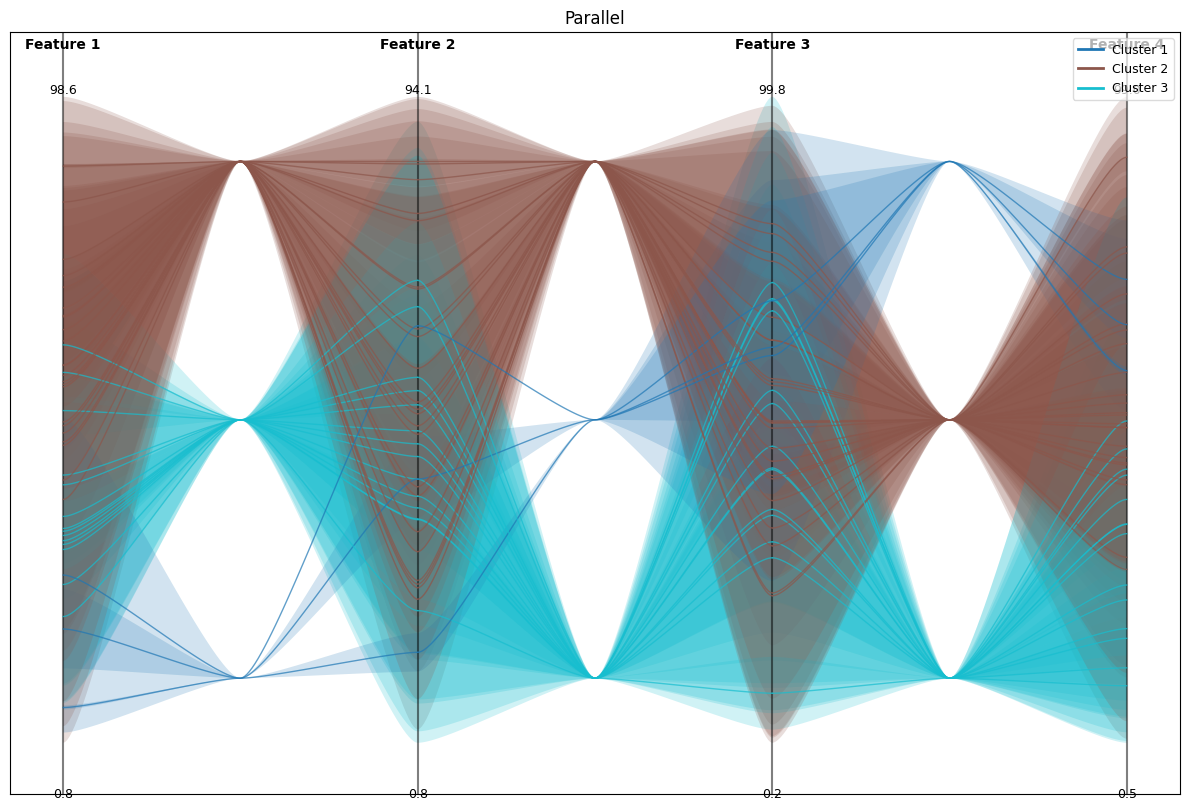

In [9]:
plt.figure(figsize=(10, 8))
IntervalParallelCoordinates.plot_interval_curves(data = random_data.get_intervals(), feature_names= None, clusters=model.labels_, beta = 1)
plt.title("Parallel")
plt.show()

/var/folders/xw/3jk8jclj72zgxr733zl929m80000gn/T/ipykernel_64735/3462875132.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap('tab10')(i/max(1, n_clusters-1)) for i in range(n_clusters)]


<Figure size 1000x800 with 0 Axes>

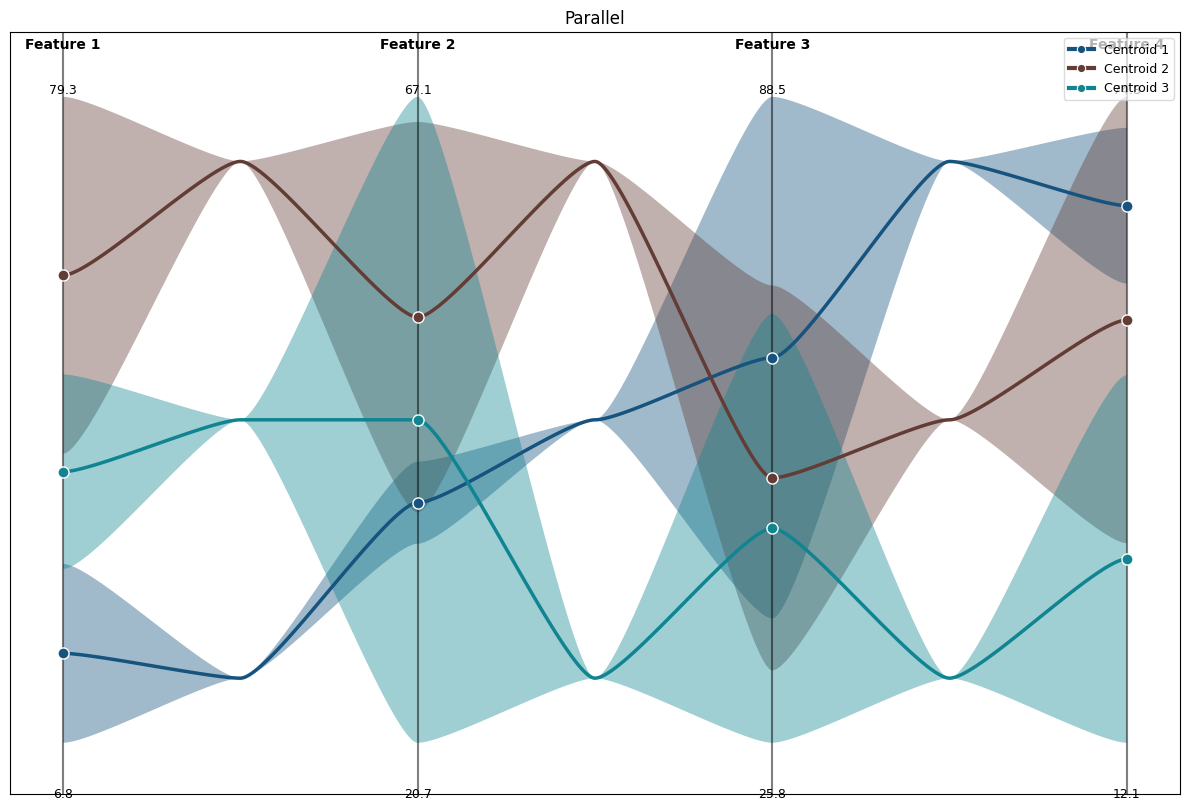

In [8]:
plt.figure(figsize=(10, 8))
IntervalParallelCoordinates.plot_interval_curves(data = None, feature_names= None, clusters=model.labels_, centroids = model.centroids_, beta = 1)
plt.title("Parallel")
plt.show()